# Imports

In [1]:
import json 
import string
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# import en_core_web_sm
nlp = spacy.load("en_core_web_sm")
# stopwords = nlp.Defaults.stop_words
from spacy.lang.en.stop_words import STOP_WORDS
# stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.decomposition import NMF
from sklearn import preprocessing
from nltk import ngrams
from nltk import FreqDist
from sklearn.decomposition import LatentDirichletAllocation as LDA
# nltk.download('all')
from nltk import pos_tag
import joblib

In [2]:
# charts
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [3]:
#warnings
import warnings
warnings.filterwarnings('ignore')

#options
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Functions

### 1. Data cleaning

In [5]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub('\S*\d\S*\s*','', text)
    text = re.sub('\[.*\]','', text)

    return text

def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in STOP_WORDS]

    return filtered_tokens

def tokenize_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)

    return tokens

# why not working
# def replace(text):
#     text = text.lower()
#     text = re.sub('xxxx','', text)

### 2. Merge cleaning functions to one function

In [6]:
def preprocess_text(text):
    cleaned_text = clean_text(text)
    tokens = tokenize_text(cleaned_text)
    tokens_without_stopwords = remove_stopwords(tokens)
    preprocessed_text = ' '.join(tokens_without_stopwords)
    
    return preprocessed_text

### 3. Restore basic forms of words

In [7]:
def lemmatize(text):
    doc = nlp(text)
    sent = [token.lemma_ for token in doc if token.text not in STOP_WORDS]

    return ' '.join(sent)

def stemming(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stem_words = [stemmer.stem(word) for word in tokens if word.text.lower() not in STOP_WORDS]
    
    return ' '.join(stem_words)

def remove_pos_tags(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']

    return ' '.join(sent)

# finding ngrams

In [8]:
def get_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return list(n_grams)

def get_top_ngrams(data, n, top=30):
    combined_text = ' '.join(data.astype(str))
    n_grams = get_ngrams(combined_text, n)
    freq_dist = FreqDist(n_grams)
    return freq_dist.most_common(top)

# Importing data 

### dataset - https://www.kaggle.com/datasets/abhishek14398/automatic-ticket-classification-dataset/data

In [9]:
path = "data/complaints.json"
open_path = open(path) 
read_data = json.load(open_path)
df=pd.json_normalize(read_data)

In [10]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [11]:
#pick only columns which are needed
df = df[['_source.complaint_what_happened', '_source.issue', '_source.product', '_source.sub_product']]

#rename for normal names
df = df.rename(columns={'_source.complaint_what_happened': 'complaint',  '_source.issue' : 'issue', '_source.product': 'product','_source.sub_product': 'sub_product'})

# drop columns with blank description
df[df['complaint']==''] = np.nan
df = df[~df['complaint'].isnull()]

df.head()

,complaint,issue,product,sub_product
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Written notification about debt,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,"Other features, terms, or problems",Credit card or prepaid card,General-purpose credit card or charge card
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",Incorrect information on your report,"Credit reporting, credit repair services, or other personal consumer reports",Other personal consumer report
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",Incorrect information on your report,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,Managing an account,Checking or savings account,Checking account


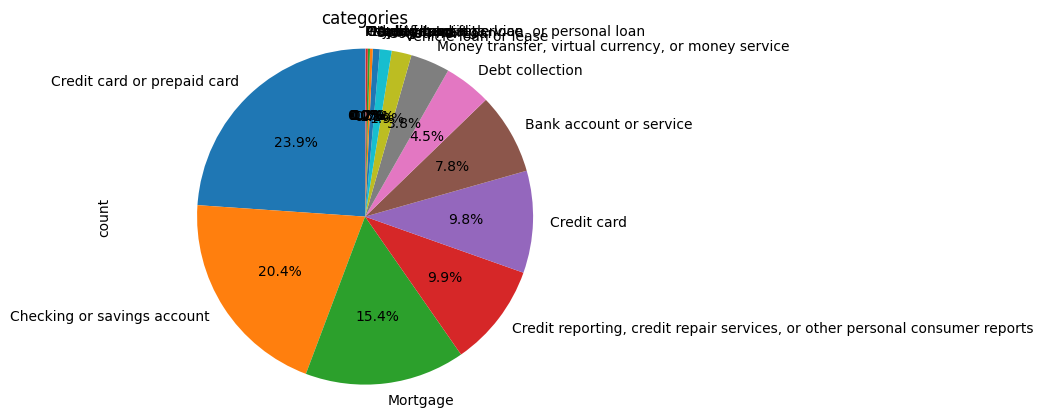

In [12]:
counts = df['product'].value_counts()
counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('categories')
plt.show()

In [13]:
# creating new column with merged 3 columns for category and droping previous columns
df['category'] = df['issue'] + ' / ' + df['product'] + ' / ' + df['sub_product']
df.drop(['issue', 'product', 'sub_product'], axis=1, inplace=True)

# text cleaning

In [14]:
data = df # replace to have possibility to load back original data
data['text_clean'] = data['complaint'].apply(lambda x: preprocess_text(x))
data['text_clean'] = data['text_clean'].apply(lambda x: lemmatize(x))
data['text_clean'] = data['text_clean'].apply(lambda x: remove_pos_tags(x))

data['text_clean'] = data['text_clean'].str.lower()
data['text_clean'] = data['text_clean'].str.replace('xxxx','')


### Check data

(array([8.454e+03, 6.287e+03, 3.049e+03, 1.433e+03, 8.430e+02, 4.590e+02,
        1.820e+02, 1.050e+02, 6.000e+01, 5.400e+01, 2.500e+01, 3.200e+01,
        1.400e+01, 1.000e+01, 1.200e+01, 8.000e+00, 9.000e+00, 4.000e+00,
        6.000e+00, 4.000e+00, 2.000e+00, 4.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([    0.  ,   209.32,   418.64,   627.96,   837.28,  1046.6 ,
         1255.92,  1465.24,  1674.56,  1883.88,  2093.2 ,  2302.52,
         2511.84,  2721.16,  2930.48,  3139.8 ,  3349.12,  3558.44,
         3767.76,  3977.08,  4186.4 ,  4395.72,  4605.04,  4814.36,
         5023.68,  5233.  ,  5442.32,  5651.64,  5860.96,  6070.28,
         6279.6 ,  6488.92,  6698.24

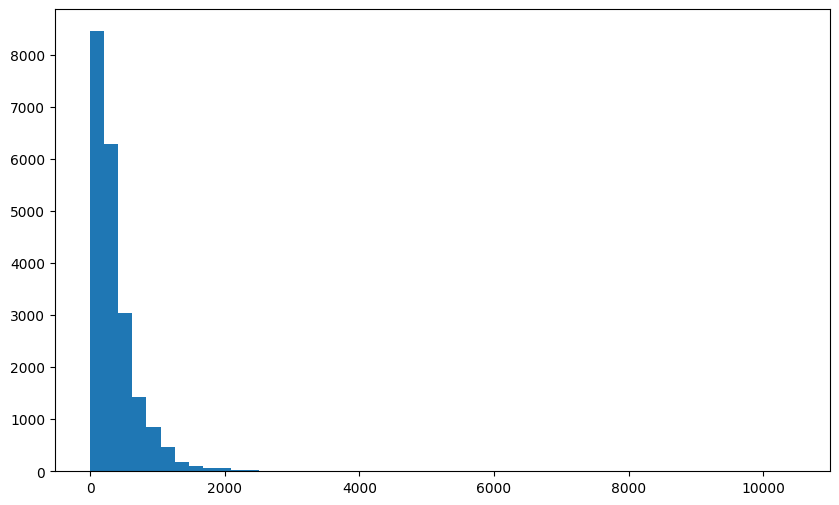

In [16]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in data['text_clean']]
plt.hist(doc_lens, bins = 50)

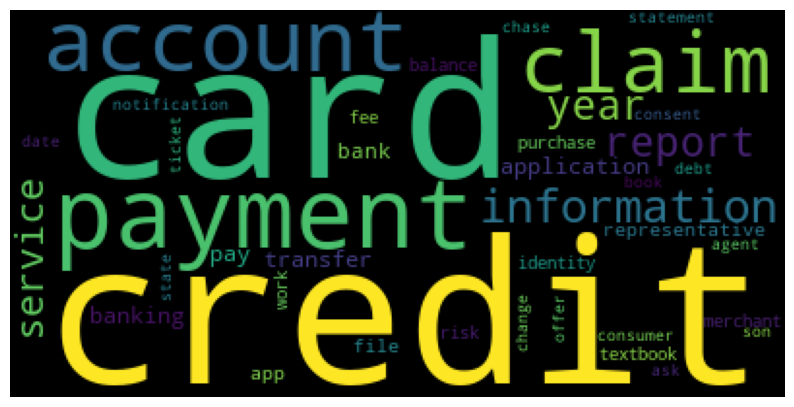

In [17]:

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(data['text_clean']))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Topic Modelling
### in this dataset I have too much categories, so my plan is to change quantity of categories to 5.
### This can be done by NFM, LDA or LSA
###
###
###

### Finding top n-grams

In [18]:
top_unigrams = get_top_ngrams(data['text_clean'], 1)
top_bigrams = get_top_ngrams(data['text_clean'], 2)
top_trigrams = get_top_ngrams(data['text_clean'], 3)


print("\n top unigrams : \n", top_unigrams[:5])
print("\n top top_bigrams : \n",top_bigrams[:5])
print("\n top top_trigrams : \n",top_trigrams[:5])


 top unigrams : 
 [(('account',), 42376), (('credit',), 30687), (('card',), 27460), (('payment',), 20605), (('time',), 15264)]

 top top_bigrams : 
 [(('credit', 'card'), 11247), (('credit', 'report'), 3710), (('check', 'account'), 2803), (('customer', 'service'), 2514), (('account', 'account'), 2011)]

 top top_trigrams : 
 [(('credit', 'card', 'account'), 1017), (('credit', 'card', 'company'), 872), (('credit', 'card', 'credit'), 509), (('charge', 'credit', 'card'), 490), (('inquiry', 'credit', 'report'), 484)]


### Vectorizer

In [7]:
# tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english', ngram_range=(1, 2))
# tfidf = TfidfVectorizer()
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

dtm = tfidf.fit_transform(data['text_clean']) # document term metrix
feature_names = np.array(tfidf.get_feature_names_out())

# cv = CountVectorizer(min_df=2, max_df=0.95, stop_words='english')
# dtm = cv.fit_transform(data['text_clean']) # document term metrix
# feature_names = np.array(cv.get_feature_names_out())

### NFM

In [8]:
from sklearn.preprocessing import normalize

num_topics = 5  # You can adjust the number of topics as needed
nmf_model = NMF(n_components=num_topics, random_state=42)
# nmf_model = NMF(n_components=num_topics)
nmf_matrix = nmf_model.fit_transform(dtm)

# Normalize the NMF matrix
nmf_matrix_normalized = normalize(nmf_matrix, axis=1)

# Assign topics to documents
data['topic'] = nmf_matrix_normalized.argmax(axis=1)


for topic in range(num_topics):
    topic_words_idx = nmf_model.components_[topic].argsort()[-15:][::-1]
    topic_words = [feature_names[i] for i in topic_words_idx]
    
    print(f"Top 15 words for Topic {topic}:\n")
    print(topic_words)
    print("\n")

Top 15 words for Topic 0:

['account', 'check', 'money', 'bank', 'deposit', 'fund', 'day', 'branch', 'transfer', 'number', 'business', 'transaction', 'chase', 'customer', 'claim']


Top 15 words for Topic 1:

['credit', 'card', 'report', 'inquiry', 'account', 'score', 'company', 'information', 'chase', 'limit', 'application', 'debt', 'letter', 'year', 'balance']


Top 15 words for Topic 2:

['payment', 'balance', 'month', 'pay', 'statement', 'fee', 'time', 'day', 'mortgage', 'date', 'credit', 'year', 'auto', 'account', 'error']


Top 15 words for Topic 3:

['charge', 'card', 'dispute', 'fee', 'transaction', 'purchase', 'merchant', 'claim', 'service', 'refund', 'fraud', 'time', 'email', 'statement', 'balance']


Top 15 words for Topic 4:

['loan', 'mortgage', 'modification', 'home', 'property', 'year', 'letter', 'document', 'rate', 'request', 'time', 'foreclosure', 'refinance', 'information', 'sale']




In [9]:
data.topic.value_counts()

topic
0    5117
3    4926
1    4815
4    3818
2    2374
Name: count, dtype: int64

### MAPPING AND SAVING DF

In [41]:
# 'Reporting/information',
# 'Credit/debits Cards',
# 'Other',
# 'Banking and Account activities',
# 'Loans/Mortgages'



topic_mapping = {
    0: 'Banking and Account activities',
    1: 'Credit/debits Cards',
    2: 'Other',
    3: 'Reporting/information',
    4: 'Loans/Mortgages'
}

#Replace Topics with Topic Names
data['topic'] = data['topic'].map(topic_mapping)

In [ ]:
data.to_csv('data/data.csv', index=False) # saving dataset

### VISUALISE DATA FOR EACH NEWLY CREATED TOPIC

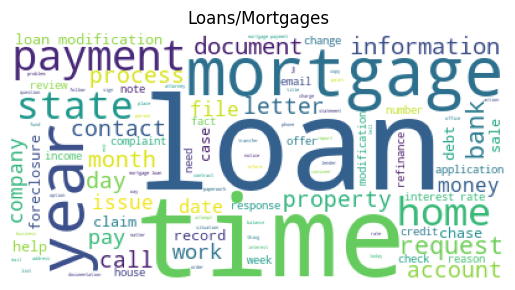

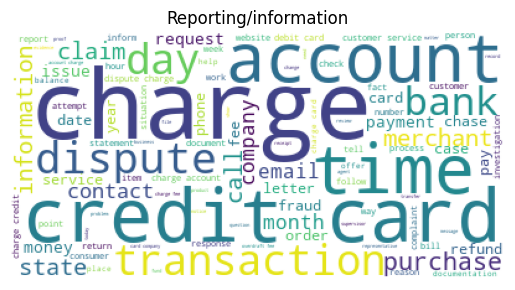

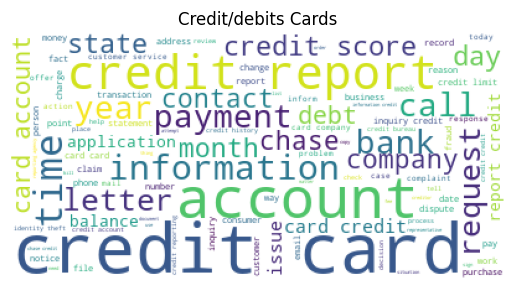

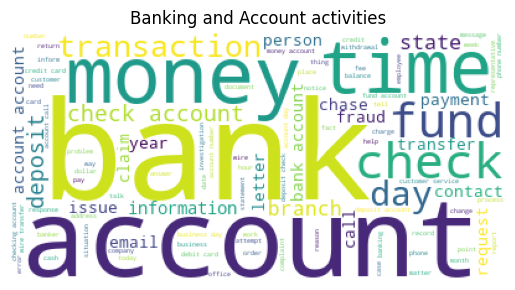

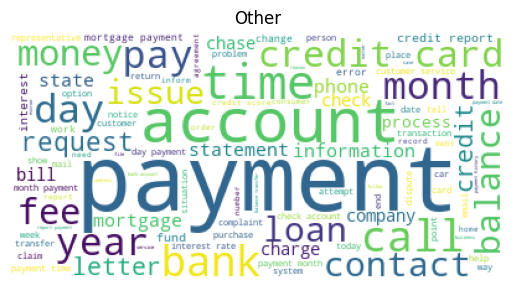

In [42]:
for x in data['topic'].unique():
	wc = WordCloud(background_color="white", max_words=100)
	# wc.generate(data['text_clean'][(data['text_clean'].notnull()) & (data['topic'] == x)].to_string())
	wc.generate(data['text_clean'][(data['text_clean'].notnull()) & (data['topic'] == x)].to_string())
	plt.imshow(wc)
	plt.title(x)
	plt.axis("off")
	plt.show()

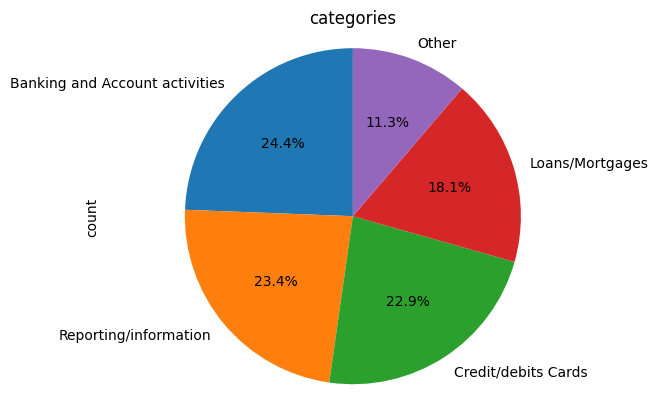

In [43]:
counts = data['topic'].value_counts()
counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('categories')
plt.show()

In [ ]:
import pandas as pd
from textaugment import Wordnet

# Data Augmentation

In [51]:
topic_counts = data['topic'].value_counts() # get the topic for each category
max_count = topic_counts.max() # max items for main topic

augmented_data = []
wordnet_aug = Wordnet(v=True) # use Wordnet for synonims

# loop for creating additional data
for topic, count in topic_counts.items():
    if count < max_count:
        topic_data = data[data['topic'] == topic]
        samples_needed = max_count - count # find how many text data we need to add for each group
        
        # perform augmenation
        augmented_sentences = []
        while len(augmented_sentences) < samples_needed:
            augmented_sentence = wordnet_aug.augment(topic_data['text_clean'].sample().iloc[0])
            augmented_sentences.append(augmented_sentence)
        
        # create new dataframe with merged newly created samples and topics
        augmented_df = pd.DataFrame({'topic': [topic] * len(augmented_sentences), 'text_clean': augmented_sentences})
        
        # add samples from list to dataframe
        augmented_data.append(augmented_df)

# merge newly created dataframe with samples and oryginal data
augmented_data = pd.concat([data] + augmented_data, ignore_index=True)

# print the results
print("Orginal data counts :")
print(data.topic.value_counts())
print("\nAugmented data counts :")
print(augmented_data.topic.value_counts())


Orginal data counts :
topic
Banking and Account activities    5117
Reporting/information             4924
Credit/debits Cards               4817
Loans/Mortgages                   3818
Other                             2374
Name: count, dtype: int64

Augmented data counts :
topic
Loans/Mortgages                   5117
Reporting/information             5117
Credit/debits Cards               5117
Banking and Account activities    5117
Other                             5117
Name: count, dtype: int64


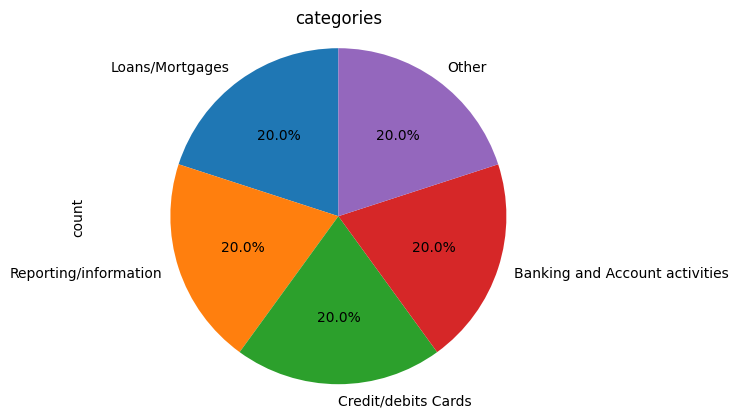

In [64]:
counts = augmented_data['topic'].value_counts()
counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('categories')
plt.show()

In [52]:
augmented_data.to_csv('data/augmented_data.csv', index=False) # saving dataset

# TESTING ON DIFFERENT CLASSIFICATORS

In [5]:
# import dataset
data = pd.read_csv('data/data.csv')
data['text_clean'] = data['text_clean'].fillna('')
data[data['text_clean']==''] = np.nan
data = data[~data['text_clean'].isnull()]

In [53]:
# training_data = data[['text_clean','topic']]
training_data = augmented_data[['text_clean','topic']]

In [56]:
training_data['text_clean'] = training_data['text_clean'].fillna('')
training_data[training_data['text_clean']==''] = np.nan
training_data = training_data[~training_data['text_clean'].isnull()]

In [57]:
X = training_data['text_clean']
y = training_data['topic']

In [58]:
cv = CountVectorizer()
X_vec = cv.fit_transform(X)
# joblib.dump(cv, 'pre-trained_models/count_vectorizer_model.joblib')

In [59]:
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code here to transform the word vector to tf-idf
#Fit transform word vector to TF-IDF
tfidf_t = TfidfTransformer()
X_tfidf = tfidf_t.fit_transform(X_vec)
# joblib.dump(tfidf_t, 'pre-trained_models/tfidf_transformer_model.joblib')

In [60]:
from sklearn.model_selection import train_test_split
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=40, stratify=y)

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import numpy as np

def classification(classifier, X_train, X_test, y_train, y_test,model_name):
    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Predictions on training and testing sets
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)

    # Extract unique classes from the target variable
    unique_classes = np.unique(np.concatenate([y_train, y_test]))

    # Convert labels to binary format for ROC curve
    y_train_bin = label_binarize(y_train, classes=unique_classes)
    y_test_bin = label_binarize(y_test, classes=unique_classes)

    # Compute ROC curve and ROC area for each class
    n_classes = len(unique_classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], classifier.predict_proba(X_test)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), classifier.predict_proba(X_test).ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



    # Accuracy Scores
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Classification Report
    print("\nTraining Accuracy:", train_accuracy)
    print("\nTraining Classification Report:")
    print(classification_report(y_train, y_train_pred, target_names=unique_classes))

    print("Testing Accuracy:", test_accuracy)
    print("\nTesting Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=unique_classes))

    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve for class {unique_classes[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(unique_classes))
    plt.xticks(tick_marks, unique_classes, rotation=45)
    plt.yticks(tick_marks, unique_classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


    metrics_dict = {
        'model': model_name,
        'Training Accuracy': train_accuracy,
        'Testing Accuracy': test_accuracy,
        'Micro-average ROC AUC': roc_auc["micro"],
        # 'Confusion Matrix': [cm]
        # 'Training Classification Report': [train_classification_report],
        # 'Testing Classification Report': [test_classification_report]
    }



In [62]:
# scaller for log reg

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression Classification


Training Accuracy: 0.9824115692788743

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.98      0.99      0.99      4094
           Credit/debits Cards       0.98      0.98      0.98      4094
               Loans/Mortgages       0.98      0.98      0.98      4094
                         Other       0.98      0.99      0.99      4093
         Reporting/information       0.98      0.97      0.98      4093

                      accuracy                           0.98     20468
                     macro avg       0.98      0.98      0.98     20468
                  weighted avg       0.98      0.98      0.98     20468

Testing Accuracy: 0.9620871604455736

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.96      0.96      0.96      1023
           Credit/debits Cards       0.97      0.95      0.96  

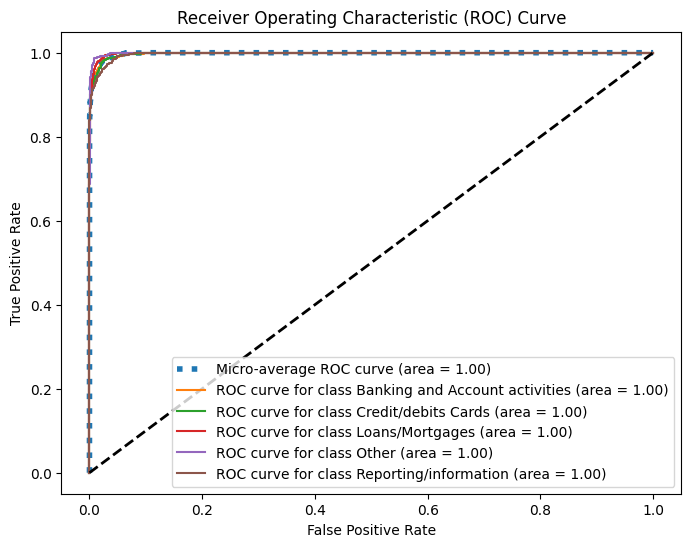

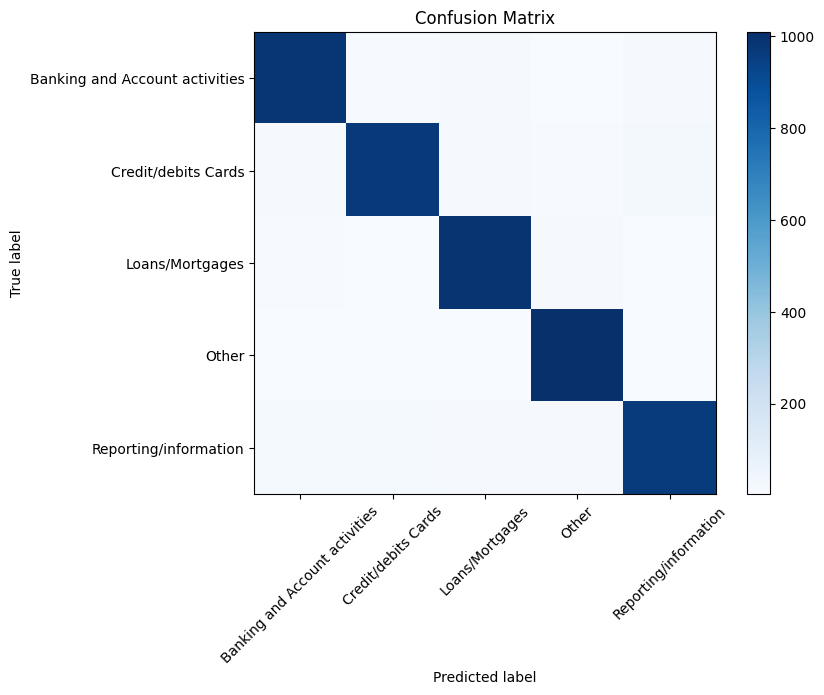

In [63]:
# augmented data
log_reg = LogisticRegression(random_state=40,solver='liblinear')
log_reg.fit(X_train,y_train)
df_metrics = classification(log_reg, X_train, X_test, y_train, y_test, 'LogisticRegression')


Training Accuracy: 0.980166270783848

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.97      0.99      0.98      4094
           Credit/debits Cards       0.98      0.98      0.98      3854
               Loans/Mortgages       0.98      0.98      0.98      3054
                         Other       0.99      0.95      0.97      1899
         Reporting/information       0.98      0.98      0.98      3939

                      accuracy                           0.98     16840
                     macro avg       0.98      0.98      0.98     16840
                  weighted avg       0.98      0.98      0.98     16840

Testing Accuracy: 0.9536817102137767

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.95      0.97      0.96      1023
           Credit/debits Cards       0.94      0.96      0.95   

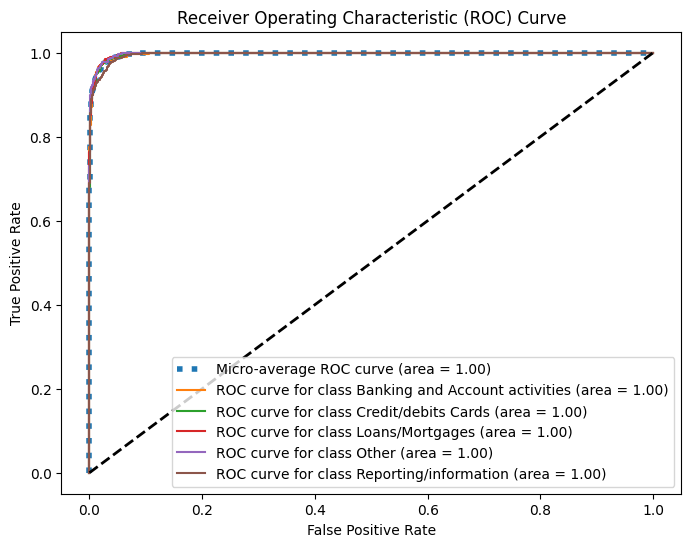

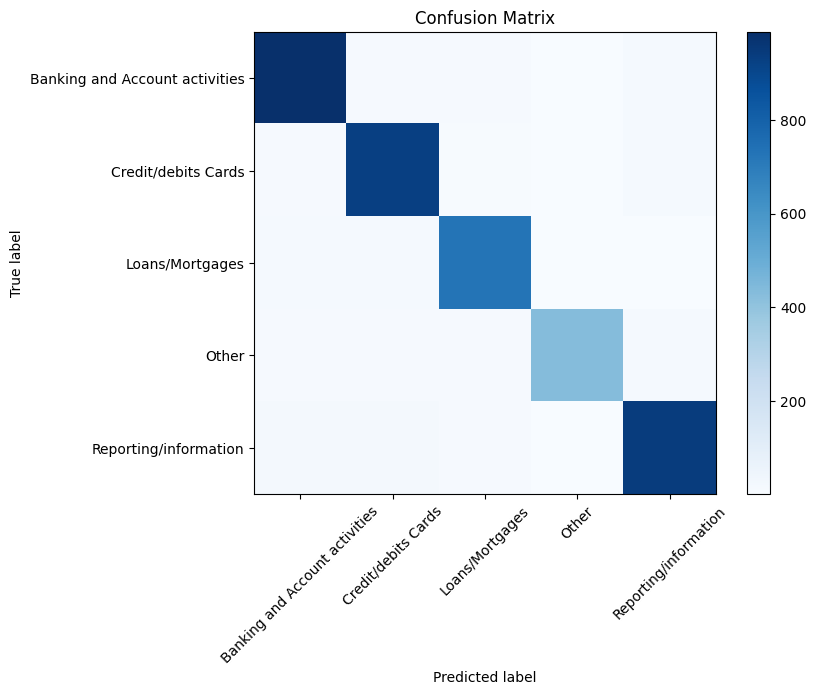

In [15]:
log_reg = LogisticRegression(random_state=40,solver='liblinear')
log_reg.fit(X_train,y_train)
df_metrics = classification(log_reg, X_train, X_test, y_train, y_test, 'LogisticRegression')

In [16]:
joblib.dump(log_reg, 'pre-trained_models/logistic_regression_model_nfm.joblib')

['pre-trained_models/logistic_regression_model_nfm.joblib']

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
# from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.gaussian_process import GaussianProcessClassifie



Training Accuracy: 1.0

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      3854
               Loans/Mortgages       1.00      1.00      1.00      3054
                         Other       1.00      1.00      1.00      1899
         Reporting/information       1.00      1.00      1.00      3939

                      accuracy                           1.00     16840
                     macro avg       1.00      1.00      1.00     16840
                  weighted avg       1.00      1.00      1.00     16840

Testing Accuracy: 0.8299287410926366

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.84      0.83      0.84      1023
           Credit/debits Cards       0.84      0.87      0.86       963
      

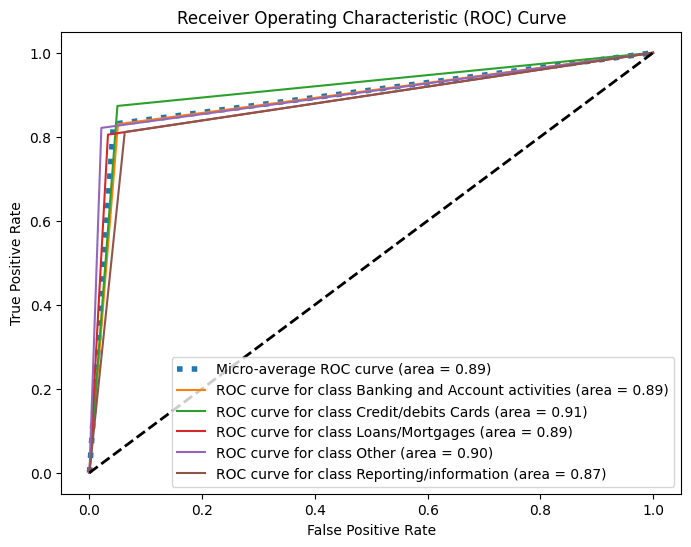

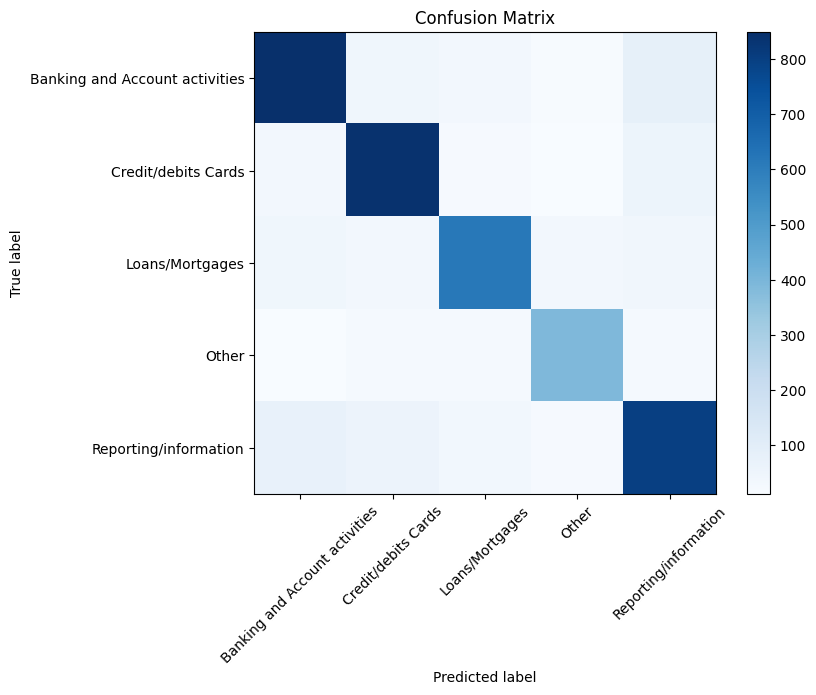

In [20]:
# decision tree
decision_tree = DecisionTreeClassifier(random_state=40)
decision_tree.fit(X_train,y_train)
classification(decision_tree, X_train, X_test, y_train, y_test, "DecisionTreeClassifier")


Training Accuracy: 1.0

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      3854
               Loans/Mortgages       1.00      1.00      1.00      3054
                         Other       1.00      1.00      1.00      1899
         Reporting/information       1.00      1.00      1.00      3939

                      accuracy                           1.00     16840
                     macro avg       1.00      1.00      1.00     16840
                  weighted avg       1.00      1.00      1.00     16840

Testing Accuracy: 0.866270783847981

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.83      0.93      0.88      1023
           Credit/debits Cards       0.86      0.89      0.88       963
       

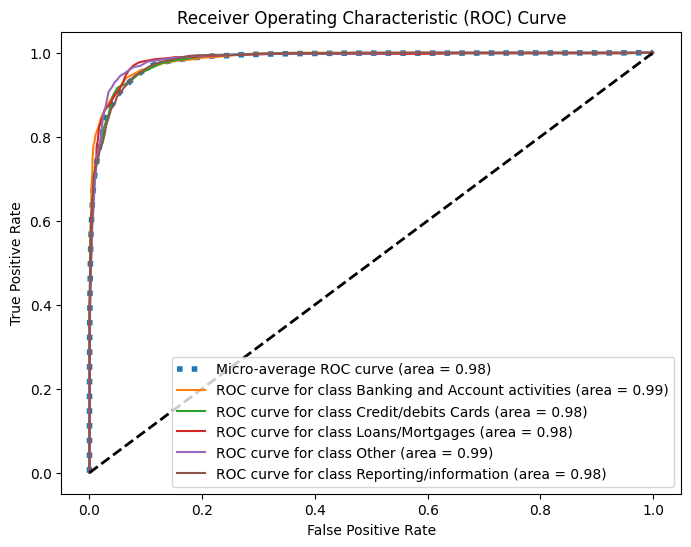

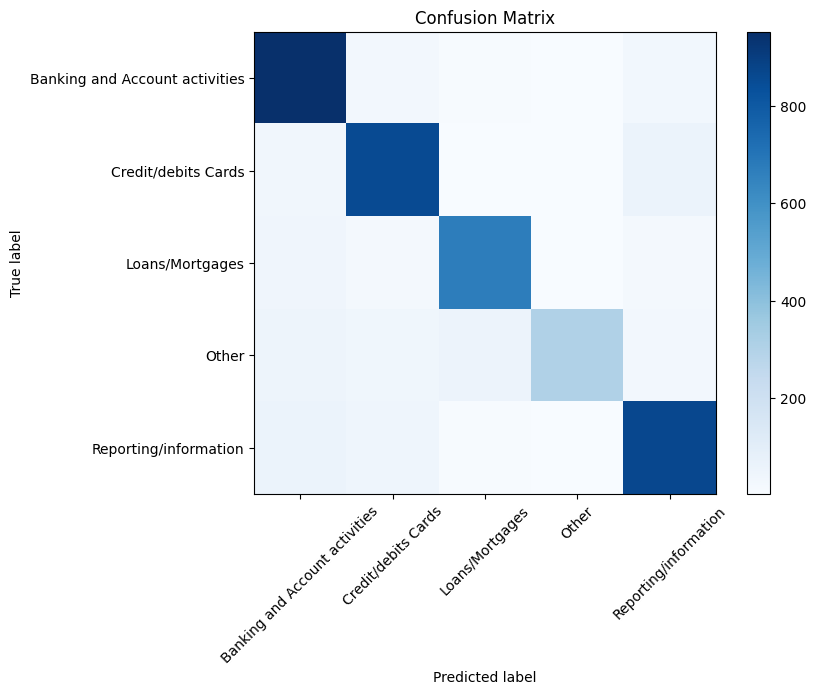

In [21]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=40)
random_forest.fit(X_train,y_train)
classification(random_forest, X_train, X_test, y_train, y_test, "RandomForestClassifier")



Training Accuracy: 0.9913895486935868

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.99      0.99      0.99      4094
           Credit/debits Cards       0.99      1.00      0.99      3854
               Loans/Mortgages       0.99      0.99      0.99      3054
                         Other       0.99      0.99      0.99      1899
         Reporting/information       0.99      0.99      0.99      3939

                      accuracy                           0.99     16840
                     macro avg       0.99      0.99      0.99     16840
                  weighted avg       0.99      0.99      0.99     16840

Testing Accuracy: 0.9456057007125891

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.95      0.95      0.95      1023
           Credit/debits Cards       0.94      0.95      0.95  

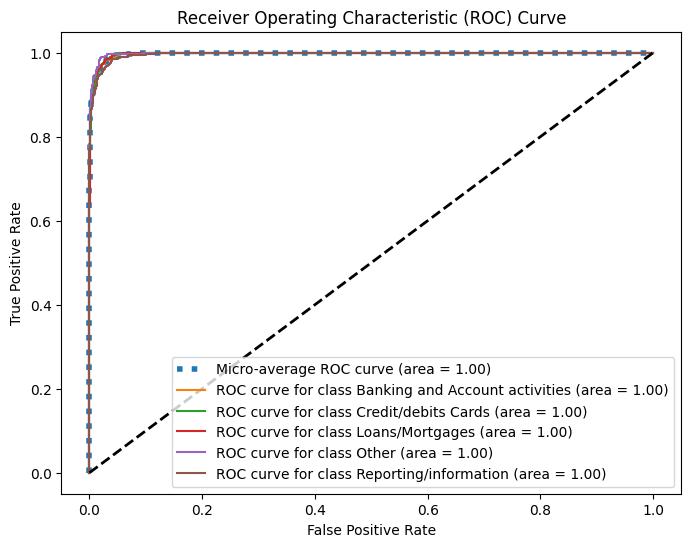

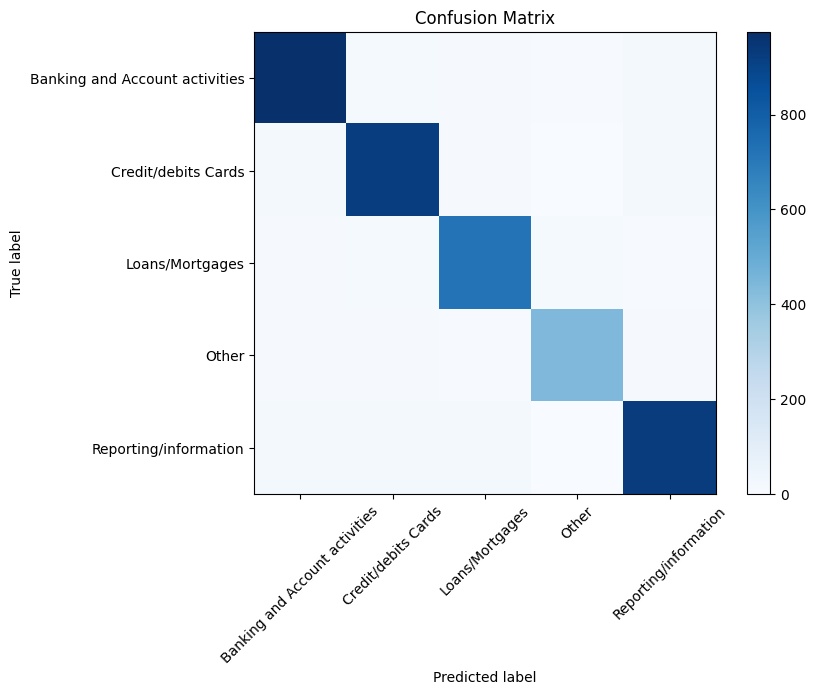

In [22]:
# Support Vector Machine (SVM)
svm_classifier = SVC(kernel='linear',probability=True, random_state=40)
svm_classifier.fit(X_train,y_train)
classification(svm_classifier, X_train, X_test, y_train, y_test, "SVC")


Training Accuracy: 0.48129453681710216

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.33      0.98      0.49      4094
           Credit/debits Cards       0.89      0.43      0.58      3854
               Loans/Mortgages       0.90      0.21      0.34      3054
                         Other       0.90      0.34      0.50      1899
         Reporting/information       0.90      0.29      0.43      3939

                      accuracy                           0.48     16840
                     macro avg       0.78      0.45      0.47     16840
                  weighted avg       0.76      0.48      0.47     16840

Testing Accuracy: 0.43824228028503565

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.31      0.97      0.47      1023
           Credit/debits Cards       0.86      0.38      0.53

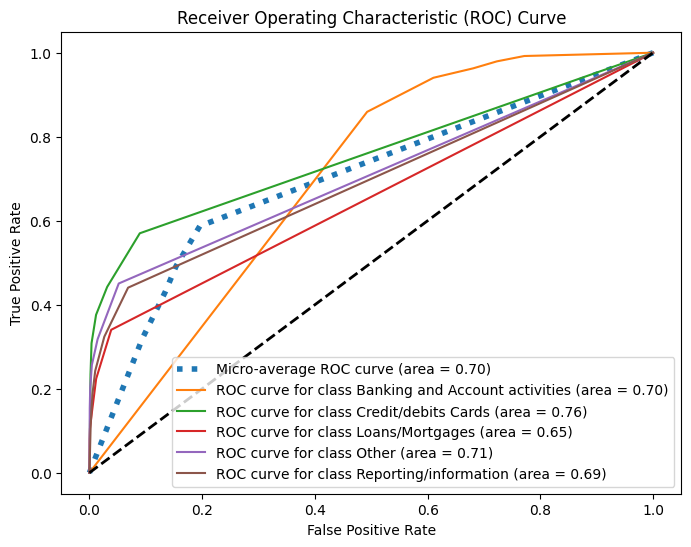

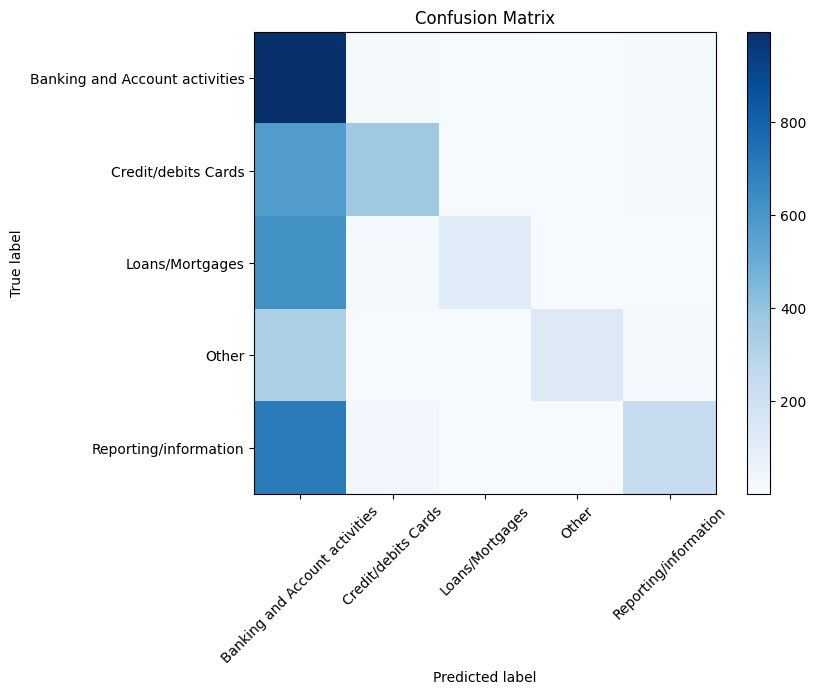

In [23]:
# K-Nearest Neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train,y_train)
classification(knn_classifier, X_train, X_test, y_train, y_test, "KNeighborsClassifier")


Training Accuracy: 0.5366389548693586

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.86      0.47      0.61      4094
           Credit/debits Cards       0.62      0.48      0.54      3854
               Loans/Mortgages       0.99      0.51      0.67      3054
                         Other       0.23      1.00      0.37      1899
         Reporting/information       0.99      0.47      0.63      3939

                      accuracy                           0.54     16840
                     macro avg       0.74      0.58      0.57     16840
                  weighted avg       0.79      0.54      0.58     16840

Testing Accuracy: 0.25486935866983373

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.38      0.19      0.25      1023
           Credit/debits Cards       0.30      0.21      0.24 

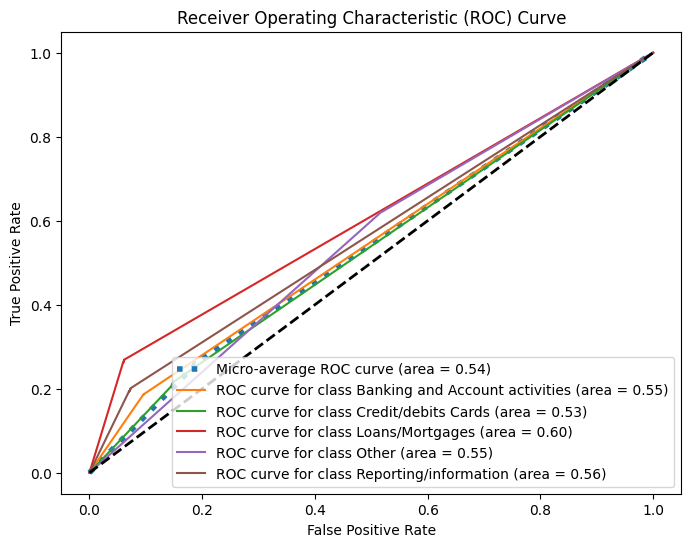

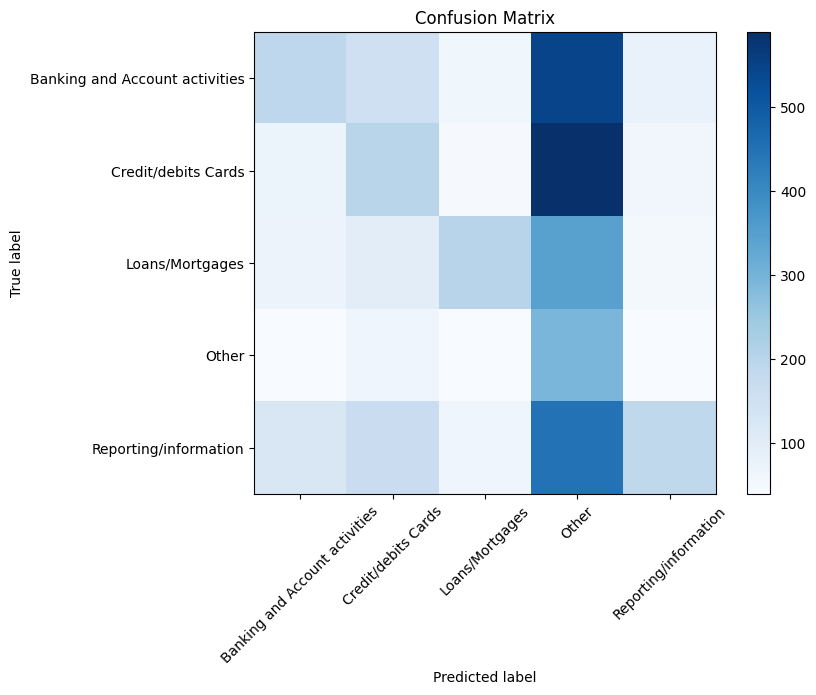

In [24]:
# Naive Bayes
naive_bayes = GaussianNB()
naive_bayes.fit(X_train.toarray(),y_train)
classification(naive_bayes, X_train.toarray(), X_test.toarray(), y_train, y_test, "naive_bayes")


Training Accuracy: 0.8501781472684086

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.89      0.88      0.88      4094
           Credit/debits Cards       0.85      0.88      0.87      3854
               Loans/Mortgages       0.82      0.83      0.83      3054
                         Other       0.77      0.90      0.83      1899
         Reporting/information       0.87      0.78      0.82      3939

                      accuracy                           0.85     16840
                     macro avg       0.84      0.85      0.85     16840
                  weighted avg       0.85      0.85      0.85     16840

Testing Accuracy: 0.8410926365795725

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.88      0.86      0.87      1023
           Credit/debits Cards       0.84      0.88      0.86  

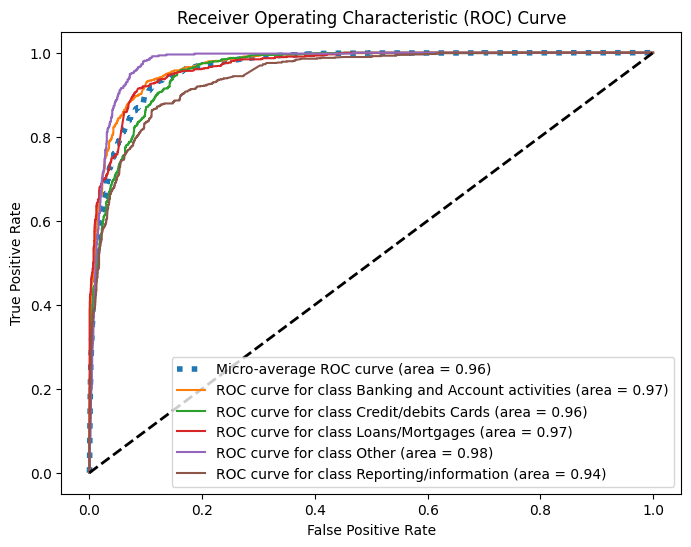

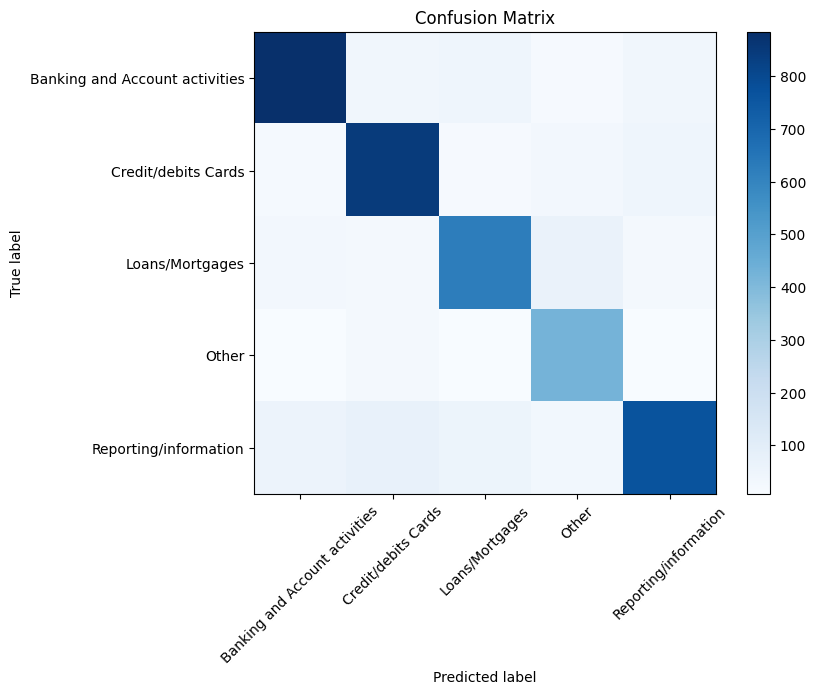

In [25]:
# AdaBoost
adaboost = AdaBoostClassifier(n_estimators=50, random_state=40)
adaboost.fit(X_train,y_train)
classification(adaboost, X_train, X_test, y_train, y_test, "adaboost")


Training Accuracy: 0.9998218527315914

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      3854
               Loans/Mortgages       1.00      1.00      1.00      3054
                         Other       1.00      1.00      1.00      1899
         Reporting/information       1.00      1.00      1.00      3939

                      accuracy                           1.00     16840
                     macro avg       1.00      1.00      1.00     16840
                  weighted avg       1.00      1.00      1.00     16840

Testing Accuracy: 0.8764845605700713

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.86      0.91      0.88      1023
           Credit/debits Cards       0.88      0.91      0.89  

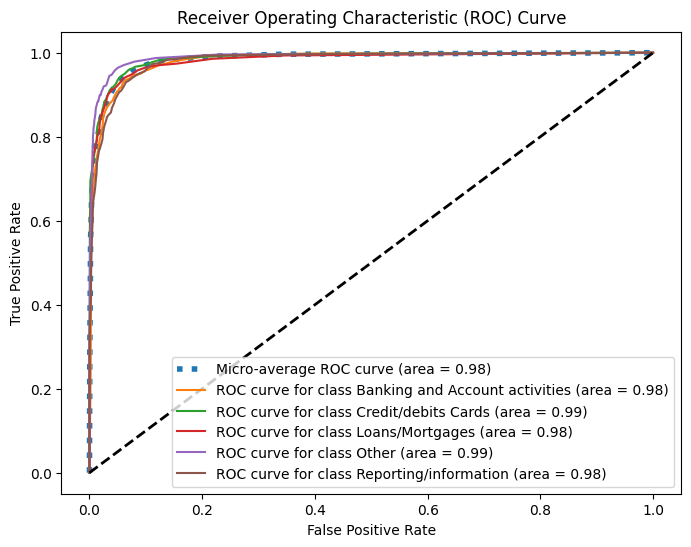

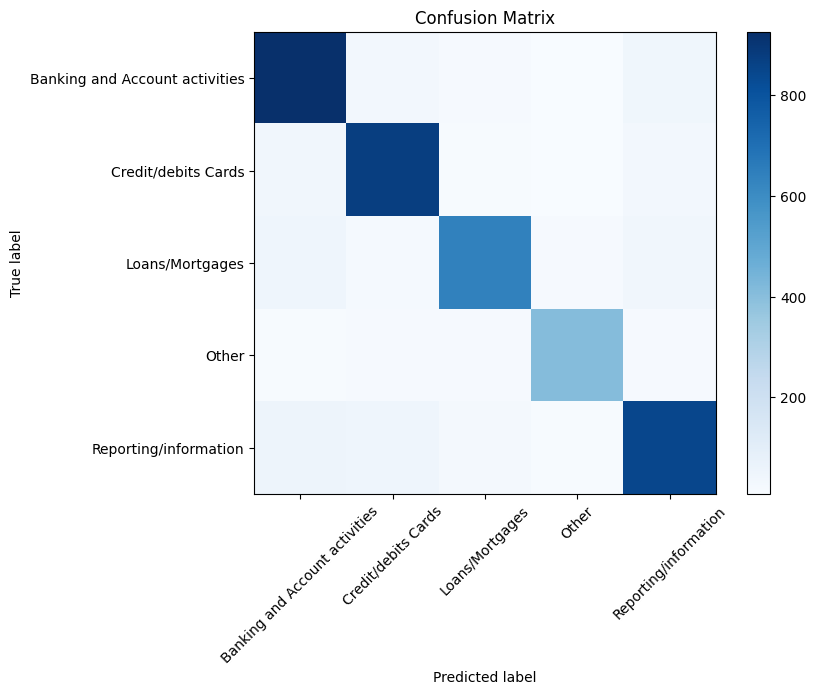

In [26]:

# Bagging
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=40)
bagging.fit(X_train,y_train)
classification(bagging, X_train, X_test, y_train, y_test, "BaggingClassifier")


Training Accuracy: 1.0

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      3854
               Loans/Mortgages       1.00      1.00      1.00      3054
                         Other       1.00      1.00      1.00      1899
         Reporting/information       1.00      1.00      1.00      3939

                      accuracy                           1.00     16840
                     macro avg       1.00      1.00      1.00     16840
                  weighted avg       1.00      1.00      1.00     16840

Testing Accuracy: 0.8643705463182898

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.84      0.94      0.89      1023
           Credit/debits Cards       0.86      0.89      0.88       963
      

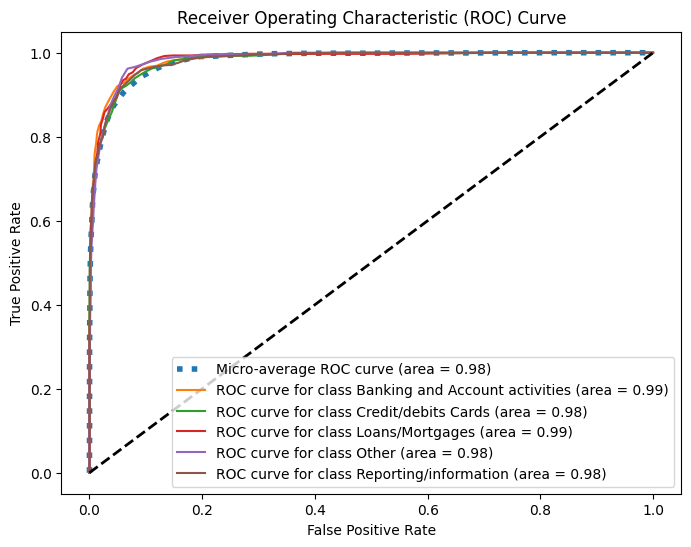

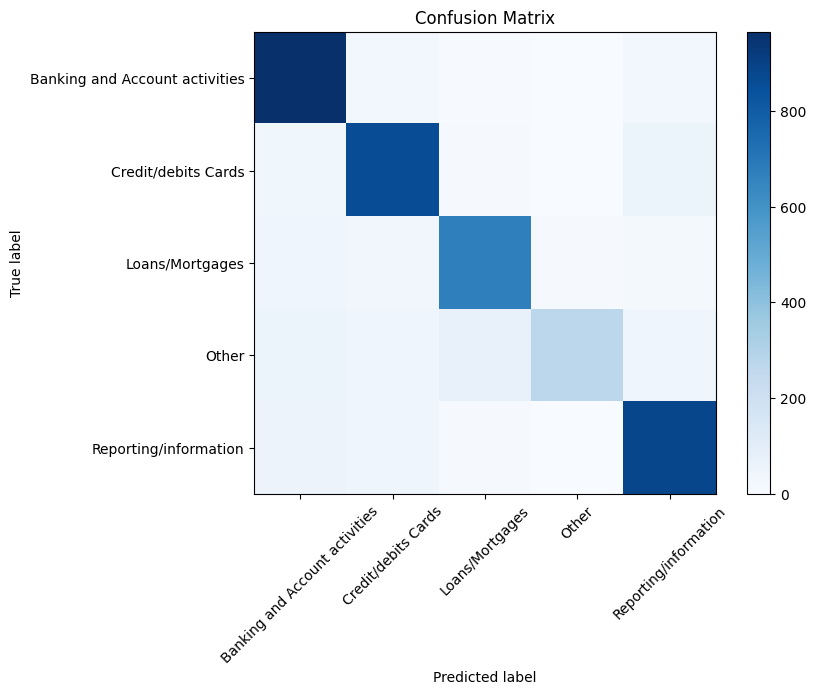

In [27]:
# Extra Trees
extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=40)
extra_trees.fit(X_train,y_train)
classification(extra_trees, X_train, X_test, y_train, y_test, "ExtraTreesClassifier")


Training Accuracy: 0.9999406175771971

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      3854
               Loans/Mortgages       1.00      1.00      1.00      3054
                         Other       1.00      1.00      1.00      1899
         Reporting/information       1.00      1.00      1.00      3939

                      accuracy                           1.00     16840
                     macro avg       1.00      1.00      1.00     16840
                  weighted avg       1.00      1.00      1.00     16840

Testing Accuracy: 0.9099762470308789

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.91      0.92      0.91      1023
           Credit/debits Cards       0.91      0.91      0.91  

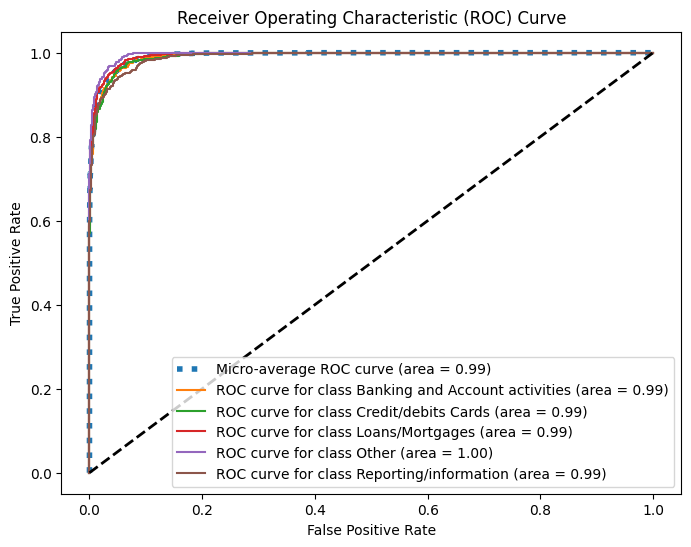

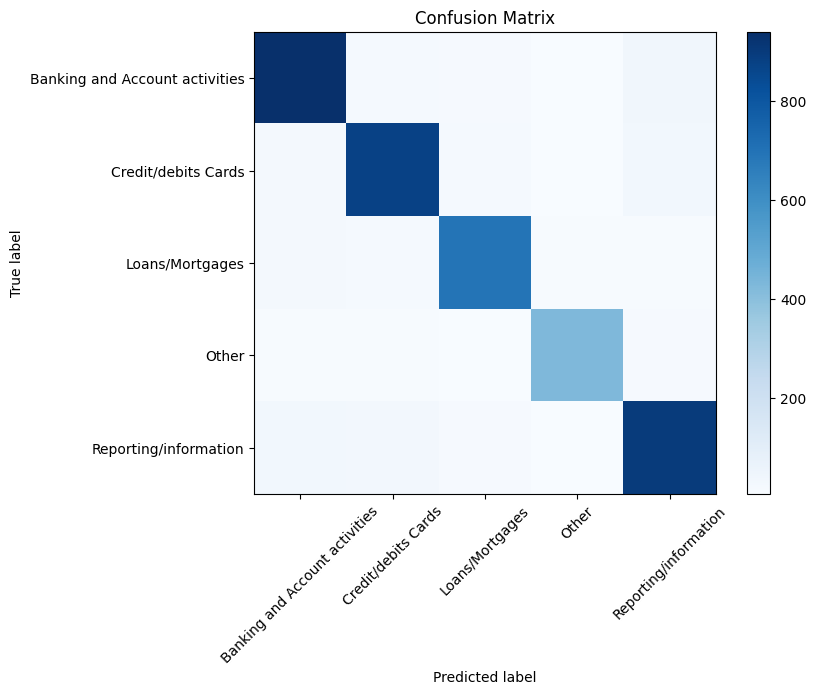

In [28]:
# Multi-layer Perceptron (Neural Network)
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=40)
mlp.fit(X_train,y_train)
classification(mlp, X_train, X_test, y_train, y_test, "MLPClassifier")



Training Accuracy: 1.0

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       1.00      1.00      1.00      4094
           Credit/debits Cards       1.00      1.00      1.00      3854
               Loans/Mortgages       1.00      1.00      1.00      3054
                         Other       1.00      1.00      1.00      1899
         Reporting/information       1.00      1.00      1.00      3939

                      accuracy                           1.00     16840
                     macro avg       1.00      1.00      1.00     16840
                  weighted avg       1.00      1.00      1.00     16840

Testing Accuracy: 0.8299287410926366

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.84      0.83      0.84      1023
           Credit/debits Cards       0.84      0.87      0.86       963
      

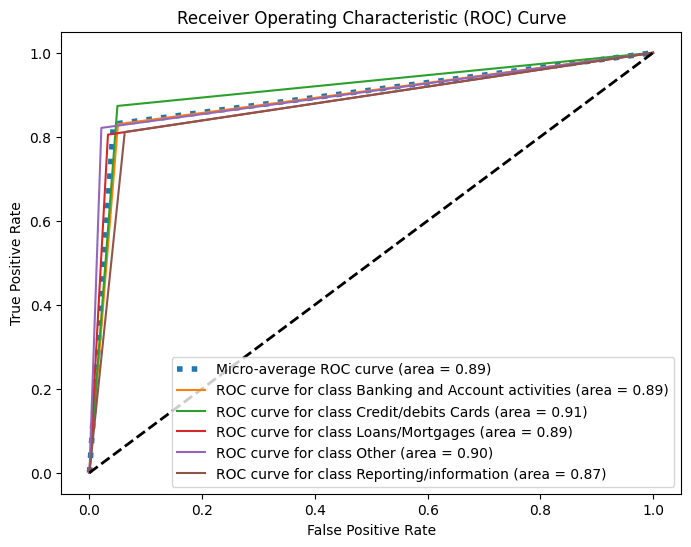

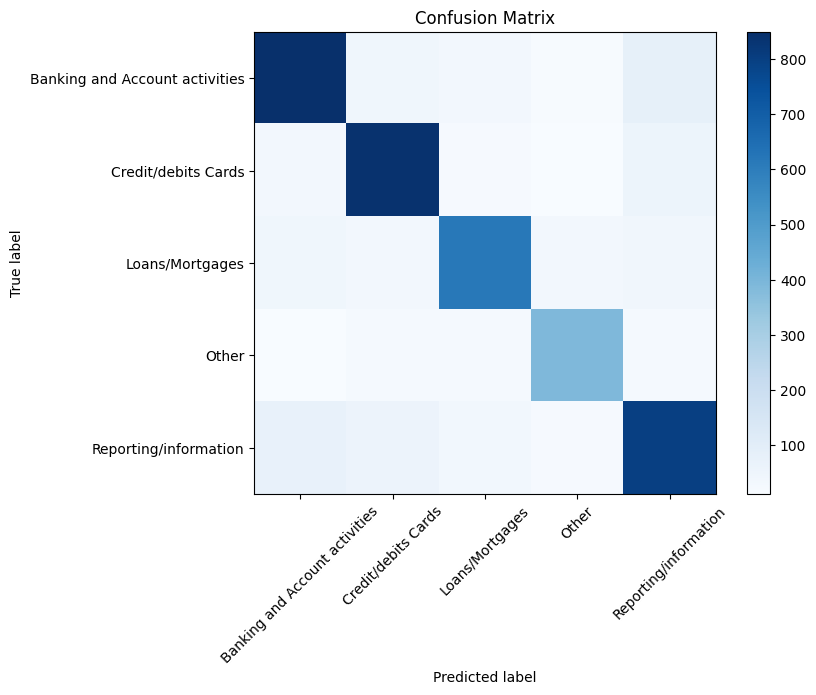

In [29]:
# decision tree
decision_tree = DecisionTreeClassifier(random_state=40)
decision_tree.fit(X_train,y_train)
classification(decision_tree, X_train, X_test, y_train, y_test, "DecisionTreeClassifier")


Training Accuracy: 0.9635985748218527

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.96      0.97      0.97      4094
           Credit/debits Cards       0.97      0.97      0.97      3854
               Loans/Mortgages       0.95      0.96      0.96      3054
                         Other       0.98      0.97      0.98      1899
         Reporting/information       0.96      0.95      0.96      3939

                      accuracy                           0.96     16840
                     macro avg       0.96      0.96      0.96     16840
                  weighted avg       0.96      0.96      0.96     16840

Testing Accuracy: 0.9175771971496437

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.92      0.93      0.93      1023
           Credit/debits Cards       0.92      0.93      0.92  

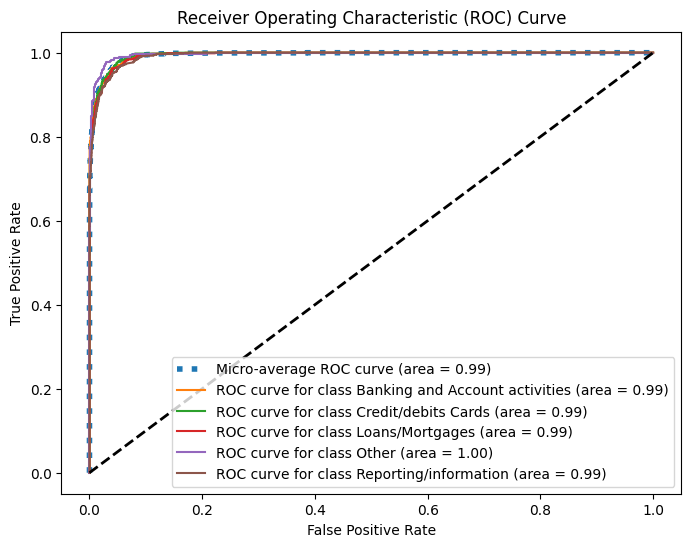

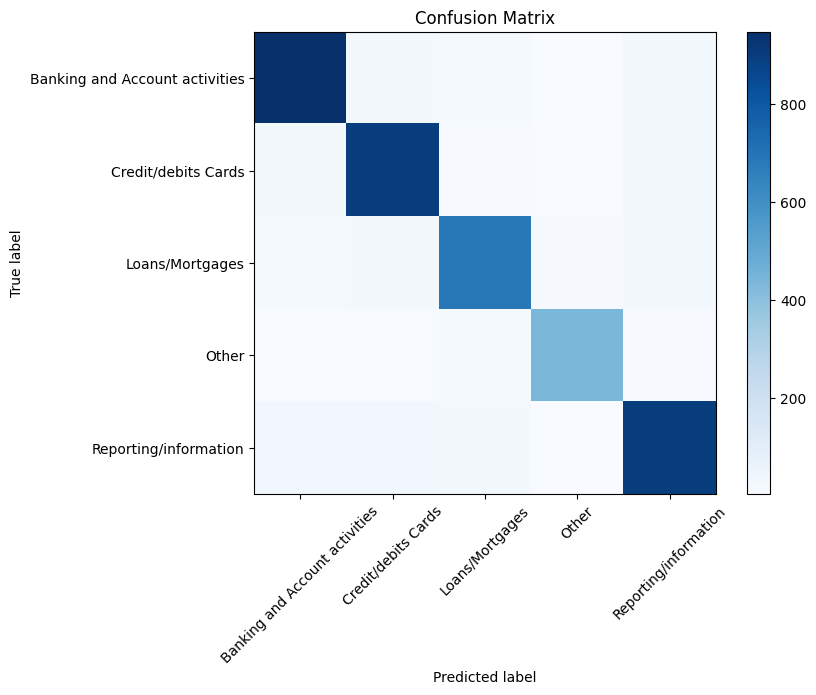

In [30]:
# Gradient Boosting
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=40)
gradient_boosting.fit(X_train,y_train)
classification(gradient_boosting, X_train, X_test, y_train, y_test, "GradientBoostingClassifier")


Training Accuracy: 0.8605700712589074

Training Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.92      0.87      0.89      4094
           Credit/debits Cards       0.65      1.00      0.79      3854
               Loans/Mortgages       1.00      0.85      0.92      3054
                         Other       1.00      0.69      0.82      1899
         Reporting/information       1.00      0.80      0.89      3939

                      accuracy                           0.86     16840
                     macro avg       0.91      0.84      0.86     16840
                  weighted avg       0.90      0.86      0.87     16840

Testing Accuracy: 0.3612826603325416

Testing Classification Report:
                                precision    recall  f1-score   support

Banking and Account activities       0.40      0.32      0.35      1023
           Credit/debits Cards       0.38      0.50      0.43  

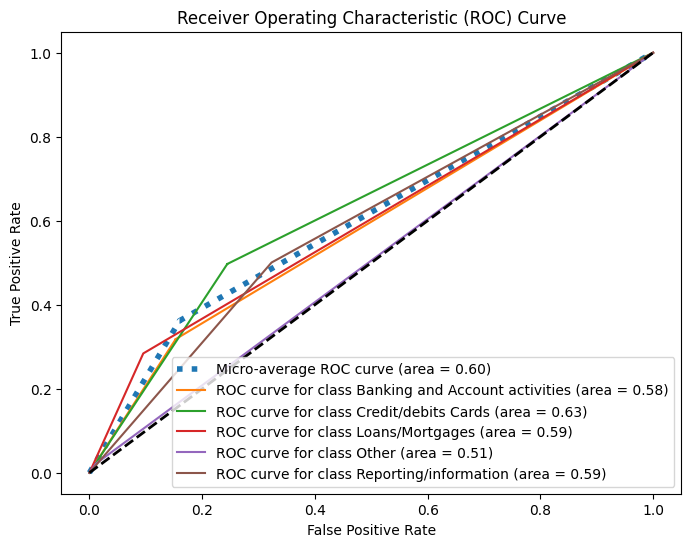

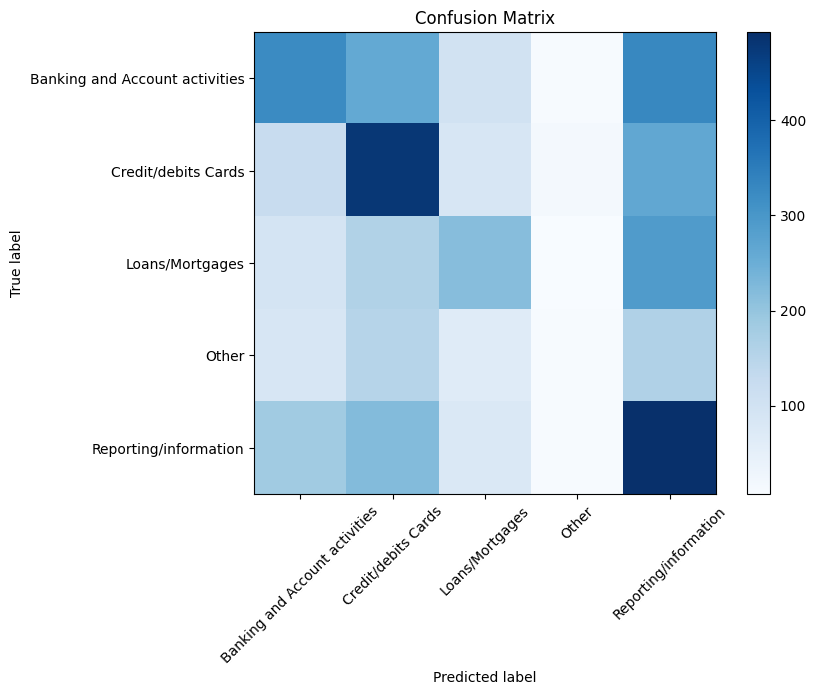

In [31]:
# QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train.toarray(),y_train)
classification(qda, X_train.toarray(), X_test.toarray(), y_train, y_test, "QuadraticDiscriminantAnalysis")

# FINAL TEST

In [ ]:
# user input
input = 'I tried to make a transaction at a supermarket retail store, using my chase \
debit/atm card, but the transaction was declined. I am still able to withdraw money out of an \
ATM machine using the same debit card. Please resolve this issue.'

In [ ]:
# text cleaning
input_clean = preprocess_text(input)
input_clean = lemmatize(input_clean)
input_clean = remove_pos_tags(input_clean)
input_clean = final_replace(input_clean)
print("\nFinal Text:", input_clean)

In [ ]:
# test = cv.transform([input])
test = cv.transform([input_clean])
test_tfidf = tfidf_t.transform(test)

In [ ]:
# classify
prediction=log_reg.predict(test_tfidf)
prediction